In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from db import PostgresDB


In [3]:
load_dotenv()


True

In [4]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
)


Connected to database


In [5]:
ICU_SCHEMA = "mimiciv_icu"
HOSP_SCHEMA = "mimiciv_hosp"
ED_SCHEMA = "mimiciv_ed"


In [6]:
def create_sepsis_cohort(db: PostgresDB):
    probands = []
    query = """
        SELECT sep.subject_id, sep.stay_id, sta.hadm_id
        FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
        WHERE sep.stay_id = sta.stay_id limit 100;
    """
    db_result = db.execute_query(query)
    for subject_id, stay_id, hadm_id in db_result:
        probands.append(
            Proband(subject_id=subject_id, stay_id=stay_id, hadm_id=hadm_id)
        )
    cohort = Cohort(participants=probands)
    return cohort


In [7]:
from cohorts import Cohort, Proband
from labevents import LabEvent, LabEventComparator

sepsis_query = """
    SELECT sep.subject_id, sta.hadm_id
    FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
    WHERE sep.stay_id = sta.stay_id limit 20;
"""

aki_query = """
    SELECT kdigo.subject_id, sta.hadm_id
    FROM mimiciv_derived.kdigo_stages kdigo, mimiciv_icu.icustays sta
    WHERE kdigo.stay_id = sta.stay_id AND kdigo.aki_stage > 2 LIMIT 10;
"""

meld_query = """
    SELECT meld.subject_id, sta.hadm_id
    FROM mimiciv_derived.meld meld, mimiciv_icu.icustays sta
    WHERE meld.stay_id = sta.stay_id AND meld.meld > 30 LIMIT 20;
"""


In [8]:
sespsis_pats = db.execute_query(sepsis_query)
meld_pats = db.execute_query(meld_query)

participants = []
for subject_id, hadm_id in sespsis_pats:
    participants.append(Proband(subject_id=subject_id, hadm_id=hadm_id))
for subject_id, hadm_id in meld_pats:
    participants.append(Proband(subject_id=subject_id, hadm_id=hadm_id))


In [9]:
sepsis_meld_cohort = Cohort(participants=participants, db=db)

In [10]:
sepsis_meld_cohort.initialize_data()
result = sepsis_meld_cohort.compare_encounters()

In [11]:
columne_names = [e["encounter_a"] for e in result]
row_names = [e["encounter_b"] for e in result]
data = [[e["similarity"] for e in result]]

df = pd.DataFrame(data=data, columns=columne_names, index=row_names)

<Axes: >

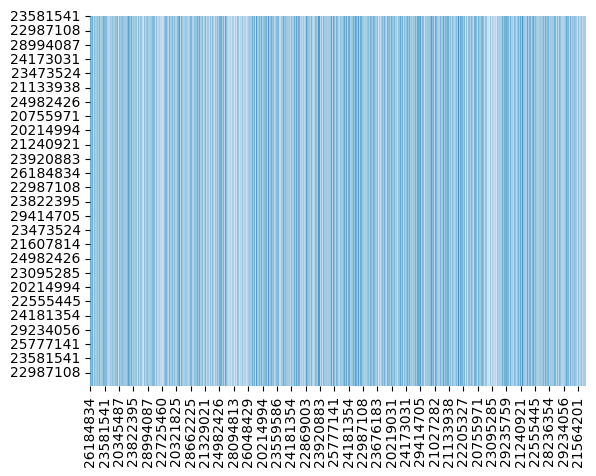

In [12]:
sns.heatmap(df, annot=False, fmt=".2f", cmap="Blues", cbar=False, vmin=0, vmax=1)